# Lecture 2: Data Manipulation

Now that we've picked up some basic tools for doing data science, we're ready to sharpen our data handling skills. As you might have already observed, data rarely comes in a neatly packaged “ready-to-use” format. We need to be able to manipulate datasets and shape them as we please so that we can run machine learning algorithms on them. Let's start with geting a little bit more comfortable with R.

## Writing Fast R

R is an excellent language for data science. However, R behaves very differently from commonly used object-oriented languages like Java and Python. Such differences can cause huge inefficiencies to unsuspecting beginners of R. Let's take a look at one of the most misunderstood concepts in R: the inefficiency of using explicit for-loops, as indicated below.

In [15]:
# Process time comparison of explicit for-loop with implicit loops.
vec <- c(1:1000000)

# explicit version
system.time({for(i in 1:1000000) { 
    vec[i] <- vec[i] * 2 
}})

# implicit version
system.time({vec <- vec * 2})

   user  system elapsed 
  0.872   0.003   0.876 

   user  system elapsed 
  0.003   0.000   0.003 

While both cases above do essentially the __same operation__, the first operation is considerably slower. At this point, most programmers will believe that R is a terrible language. But not so fast!

### The less you use R, the faster R gets!
The key here is that R is a _high-level language_. This means that R is not actually the underlying machinery behind much of its available functionalities; rather, R uses C and Fortran. Why not just use C you say? That would be a nightmare to utilize. The whole purpose of the R language is to make these low-level programs easy to manage and use in the context of data science.  

Each function call in R requires searching through its environment to find the function source code, registering the accompanying parameter inputs, evaluating data structure of handled object, and data type before passing it to C or Fortran. This "translation" is the root cause of slow R code. What aggravates this situation is that R objects are mostly _immutable_: R objects cannot be changed once created. There are good reasons - resilience of data being one - for such a choice. But this choice forces R to create new environment and new objects whenever changes are made to an object. 

### Golden Rule #1 for fast R code: Vectorize
Take the first case, for example. What is this code doing? This code forces R to constantly "change" objects. In fact, it does so 1000000 times. Every single time, R has to create new environments and figure out data types etc. What about the second case? In this case, R needs to only change this object once. That is, it knows the resulting object's general size will be the same length as the original object even without doing all 1000000 calculations, it needs to create only one additional object and environment, and also can figure out the data types of all elements it will encounter for the entire period. Thus R overhead is significantly lower for the second operation.

This concept is known as __vectorization__, and is incredibly important concept in R. 

### Golden Rule #2 for fast R code: Minimize the number of vectors to operate on
Following the first rule, one should aim to vectorize as much as possible. Even then, there are ways to make things more efficient. For a matrix that is longer than wide, we should iterate over column vectors, rather than row vectors. Why? Because this reduces the total number of times R must create new environments and reinitialize.

### The Apply() Family
One way to make streamline vectorization in R is to make use of the `apply` family of functions, also called __functionals__. These are a great substitute for for-loops when a vectorized function isn't immediately available. Under the hood, they have for-loops underneath but try to optimize by minimizing R overhead. 

Here are some of the more commonly used functions in the `apply` family:

* **`apply(X, MARGIN, FUN, ...)`** - returns a vector or array or list of values applying a function 'FUN' to margins 'MARGIN'
margin = 1 iterates over rows, margin =2 columns and c(1,2) for each elements. 
* **`lapply(X, FUN, ...)`** - Iterates over a list object to produce a list.
* **`sapply(X, FUN, ...)`** - a wrapper of lapply by default returning a vector or matrix
* **`tapply(X, INDEX, FUN)`** - group an atomic object X (typically a vector) by a list of one or more factors and apply a function

Please refer the demo below for reference on how to use it!

In [42]:
# ** is the equivalent of ^ in R. so 10**2 = 100!

# apply demo
x <- matrix(c(1:10000), nrow = 100)
a <- apply(x, 1, FUN = function(x)(x ** 2))

a <- apply(x, 2, FUN = mean)

a <- apply(x, c(1,2), FUN = function(x){x ** 2})

# lapply demo
library(datasets)
a <- lapply(iris[1], FUN = function(x){x ** 2})

# sapply demo
a <- sapply(iris[1], FUN = function(x){x ** 2})

* There are various other R style tips that have been agreed upon by the R community [3]. As insignificant as they may seem, adopting these conventions makes your code easier to read and understand. Some of the more memorable rules include:
  
   * Use `<-` instead of `=` for assignment to avoid confusion with function keyword arguments.
   * Name your variables using dots as word delimiters, like `my.variable.name`. Don't use `snake_case` or `camelCase`.
   * Put spaces around infix operators like `<-` and `*`. For example, `3 * 5` rather than `3*5`
      
For more style tips, go to https://github.com/jimhester/lintr and scroll to the bottom. You can also download the `lintr` package on CRAN and run it on your code to automatically find violations of these rules (this is called a _linter_)

## Cleaning Data

If you've already done some data manipulation before, you've probably encountered data that was "messy" in some way. These inconsistencies in the data can often be obstacles to productivity. Visualization and analysis are painstaking processes with unclean data, and many of the predictive models built into R simply can't accommodate data that hasn’t been cleaned properly.

We can think of the process of doing data science as a pipeline. We put raw data into the pipeline and after doing some work we expect insights, visualizations and predictions to come out. The Statistics Netherlands group has put together this neat visualization describing the pipeline [4]:

<img src="https://github.com/cdstrainingprogram/cdstrainingprogram.github.io/blob/master/resources/pipeline.png?raw=true" style="width: 350px;"/>

(Source: https://cran.r-project.org/doc/contrib/de_Jonge+van_der_Loo-Introduction_to_data_cleaning_with_R.pdf)

Each step of the way, we add value to the data. Raw data is data in its least valuable state, while the final processed results are most valuable. It’s important to understand that the data pipeline isn’t a one-shot, linear process. Sometimes, unexpected results appearing later in the pipeline are sufficient cause for going back to the drawing board and starting back at the top. 

In large teams, the data pipeline is part of a much larger development operations process that spans across the entire organization. The data cleaned and processed by data scientists is used by software developers, and the results of data scientists’ work are often seen by customers themselves (for example, think of the recommendations produced by Amazon’s or Netflix’s machine learning algorithms). 

## tidyr - Preprocess for Data Manipulation

Datasets are deemed to be organized and easy to work with if all rows are *observations* and all columns are *variables*. Often this process requires very meticulous preprocessing on datasets. This task becomes daunting as the data becomes larger and larger. Even though the standard R already includes functions to support such a preprocessing, we are going to introduce a library, tidyr, which helps us organize data easily.

First let's take a look at an example of a "messy" dataset.

In [43]:
# sample data.frame
sample1 <- data.frame("Name" = "Hermione", "Freshman" = 4.0, "Sophomore" = 4.3, "Junior" = 4.1)
sample1

Name,Freshman,Sophomore,Junior
Hermione,4,4.3,4.1


This data.frame contains GPA of students. Even though this data might look fine, it is not exactly a "tidy" data yet. Every year, each student will have a new GPA for the year and it will be added to this database. Therefore, the year of a student and GPA are both observations. However, in this table, the year of a student is treated as a variable. We can easily fix this by using *gather( )* funciton.

In [46]:
# import tidyr
library(tidyr)

# DEMO for gather
gathered <- gather(sample1, Year, GPA, Freshman:Junior)
gathered

Name,Year,GPA
Hermione,Freshman,4.0
Hermione,Sophomore,4.3
Hermione,Junior,4.1


Function *spread( )* is a complement to *gather( )*

In [47]:
# DEMO for spread
spread(gathered, Year, GPA)

Name,Freshman,Junior,Sophomore
Hermione,4,4.1,4.3


While *gather( )* takes multiple columns and convine them, *unite( )* and *spread( )* can manipulate data from single column. Let's take a look.

In [48]:
# sample data.frame
sample2 <- data.frame("Profile" = c("Amit: CS", "Dae Won: OR", "Chase: IS", "Jared: CS", "Kenta: CS"))
sample2

Profile
Amit: CS
Dae Won: OR
Chase: IS
Jared: CS
Kenta: CS


Let's split Profile column into 2 columns, Name and Major

In [49]:
# DEMO for separate
separated <- separate(sample2, Profile, c("Name", "Major"), sep = ": ")
separated

Name,Major
Amit,CS
Dae Won,OR
Chase,IS
Jared,CS
Kenta,CS


Similar to *spread( )*, *unite( )* is a complement to *separate( )*.

In [50]:
unite(separated, "TAs", c(Name, Major), sep = " -> ")

TAs
Amit -> CS
Dae Won -> OR
Chase -> IS
Jared -> CS
Kenta -> CS


In large teams, the data pipeline is part of a much larger development operations process that spans across the entire organization. The data cleaned and processed by data scientists is used by software developers, and the results of data scientists’ work are often seen by customers themselves (for example, think of the recommendations produced by Amazon’s or Netflix’s machine learning algorithms). 

For more information on the data pipeline, check out this paper: https://cran.r-project.org/doc/contrib/de_Jonge+van_der_Loo-Introduction_to_data_cleaning_with_R.pdf

Let’s now dive into the specifics. Below we cover eleven techniques for making data easier to work with.

## Data Manipulation Toolbox

Let’s think about how we can transform data into formats that are easy to work with. Conceptually, we can think of a dataset as a matrix with data points as rows and variables (__features__) as columns. 

We could choose to extract certain rows from the matrix and ignore others. Similarly, we could focus our attention on certain columns and ignore the rest. We could also combine matrices with each other, perform mathematical transformations on them, or attempt to summarize their contents. These operations make up the vocabulary of data manipulation.

We’re going to look at each of these tools in detail and see how they can be implemented in R using both builtin functions and the dplyr package. For those who know SQL, examples are also provided using sqldf, an R library that allows SQL querying on R objects.

In [51]:
library(dplyr)
library(plyr)
library(sqldf)

dat <- iris

### Data Manipulation Tool #1: Filtering

Filtering is selecting a subset of a data frame’s rows. This is a way of capturing only those rows (data points) that satisfy a certain property. This is useful if you want to ignore data points that won’t be useful for your analysis, or separate out specific data points that might be especially useful.

In [52]:
#filtering
example <- dat[which(dat$Sepal.Length>6),]      #base function
example <- dplyr::filter(dat, Sepal.Length > 6) #dplyr function
example <- sqldf("SELECT * FROM dat WHERE [Sepal.Length]>6")       #sql WHERE clause

### Data Manipulation Tool #2: Subsetting

Subsetting is selecting a subset of a data frame’s columns. You’d use subsetting when you want to capture only part of the attributes of each data point. Use subsetting when you want to focus on specific variables in the data and ignore those variables that are irrelevant.

Subsetting will come in handy in a few lectures when we discuss things like feature selection and model optimization.

In [53]:
#Subset selection
example <- dat[,c(1,3,4)]                       #Matrix notation
example <- dat[c(1,3,4)]                        #List notation
example_1 <- dplyr::select(dat, c(1,3,4))       #dplyr select 
example_2 <- dplyr::select(dat,Sepal.Width)     #dplyr select
example<-sqldf("SELECT [Sepal.Length] FROM dat")#sql SELECT clause

### Data Manipulation Tool #3: Combining

Merging is used when you want to glue two data sets together. You can do this in one of two ways:

1. Combine the data sets by column. This results in the two datasets pasted side-by-side, combined into a single data frame.

2. Combine the data sets by row. This results in a long dataset in which the first group of rows belongs to the first dataset and the second group of rows belongs to the second dataset.

In [26]:
#Combining datasets
ind <- c(1:nrow(dat))
example_1<-cbind(ind,example_1)                 #combine by column
example_2<-cbind(ind,example_2)     
weird_example <- rbind(example, example)        #Combine by row

### Data Manipulation Tool #4: Joining

Joining is a variant of merging that takes an extra step: it fuses together rows that have the same value for a column. This is useful for combining two tables that refer to different parts of the same data. In the example below, the tables are related by the variable `ind`.

In [37]:
#Joining (think VLOOKUP)
example <- merge(example_1,example_2,by='ind')  #base R function
example <- plyr::join(example_1,example_2,
                      by='ind',type='left')     #plyr join
example <- sqldf("SELECT * FROM example_1 LEFT JOIN example_2 ON example_1.ind=example_2.ind")    #sql join

### Data Manipulation Tool #5: Feature Generation using dplyr::mutate

Mutating applies an operation to every element in a data frame. You can think of it as a more general version of the `apply` functions encountered earlier. Mutation is useful when you want to apply mathematical operations to every element in a column or every row in a data frame. 

We’ll see that mutation is useful for things like standardizing and normalizing, which are in the Data Cleaning Toolbox section below.


In [28]:
# mutating - feature generation
iris_new <- mutate(.data=iris, new_feature = Sepal.Width + Sepal.Length*Petal.Width)
head(iris_new,2)

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species,new_feature
5.1,3.5,1.4,0.2,setosa,4.52
4.9,3.0,1.4,0.2,setosa,3.98


### Data Manipulation Tool #6: Summarizing

Summarizing is a general term that refers to computing any sort of statistics or information about the data frame as a whole. You may want to compute the mean or standard deviation of a column, or count the number of instances of a particular occurrence in the dataset. Summarizing is a powerful way to understand the underlying mechanics of a dataset. Note that the British spelling (summarise) is used.

In [36]:
#aggregation and counting
df <- aggregate(formula = Petal.Width~Species,  #aggregate mean
                data = iris, FUN=mean)
df <- plyr::count(iris, vars='Species')         #count using plyr
df <- sqldf("SELECT Species,count(Species)      
            AS count FROM iris
            GROUP BY species")                  #count using sql

#summarize
df <- summarise(iris, avg = mean(Sepal.Length)) #summary statistic
df <- summarise_each(iris[1:4], funs(mean))

## Techniques for Working with Data

We’ve learned the grammar of data manipulation. Now it’s time to perform higher level operations on our data. We’ll be using our newfound knowledge of data manipulation techniques to perform these operations.

There are no hard and fast rules for working with data, but we’d like to share a few techniques that work well when converting a dataset into a usable format.

### Technique #1: Binning

Often, you will encounter numerical variables that can be discretized into several categories.  By converting these variables into discrete chunks (a process called binning), you can make your model more interpretable and have greater flexibility when dealing with different ranges of values [5].

For example, consider a dataset the distribution of weights of various boxers.  If your goal is to predict the performance of a given boxer, you could bin  the  data  into  weight  classes  (lightweight,  middleweight,  and  heavyweight).  By doing this, you improve predictive performance since boxers in the same weight category are matched against each other.

In [30]:
# Code example of binning the Sepal.Length feature 
# of a random sample of 10 iris data points into three bins

ind <- sample(c(1:150),10) # randomly sample 10 indices to look at from 150 rows of Iris
dat <- iris[ind,1]         # take the 10 random data points in iris' Sepal.length feature  
original.dat <- dat # originial format

#binning using cut()
bins<- cut(original.dat,3)

result <- as.data.frame(list(original.dat, bins))
names(result) <- c("original","bins")
result

original,bins
6.5,"(6.27,6.9]"
6.9,"(6.27,6.9]"
5.8,"(5.63,6.27]"
5.0,"(5,5.63]"
6.0,"(5.63,6.27]"
6.4,"(6.27,6.9]"
5.8,"(5.63,6.27]"
6.1,"(5.63,6.27]"
6.1,"(5.63,6.27]"
6.0,"(5.63,6.27]"


### Technique #2: Normalizing and Standardize

__Normalize:__
Many predictive models work best when features follow a bell curve. In statistical terms, this is called normal (Gaussian) distribution and it occurs when most of the data is centered around the mean. Data can sometimes be skewed to the left or right. Examples of skewed datasets are shown below:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Negative_and_positive_skew_diagrams_(English).svg/446px-Negative_and_positive_skew_diagrams_(English).svg.png"></img>

(Source: https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Negative_and_positive_skew_diagrams_(English).svg/446px-Negative_and_positive_skew_diagrams_(English).svg.png)

This handout from Northern Arizona University illustrates some of the transformations you can apply if your dataset is skewed: http://oak.ucc.nau.edu/rh232/courses/eps625/handouts/data%20transformation%20handout.pdf

__Standardize:__

Some models can be influenced by the magnitude of your features, giving undue weight to certain variables simply because they’re larger in size. Because of this, it's often a good idea to standardize features that are approximately distributed in a bell curve - this gives them a mean of 0 and a standard deviation of 1.
    
Note: you should only use standardization if you won't lose any information by reducing the scale of the feature. Certain features, like latitude and longitude, may need to be preserved as they are. You should only use standardization if what matters is the relative differences between values, not the values themselves [5].

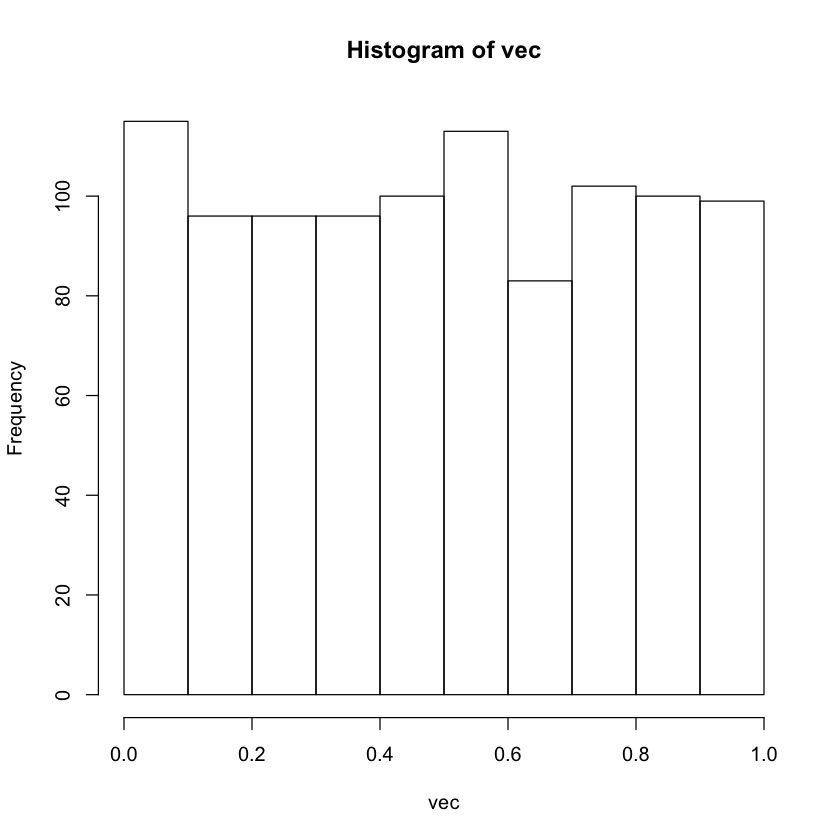

In [34]:
# Both can be done using scale(), use scale.
# center parameter subtracts the mean from the values
# scale divides by the standard deviation.
vec <- runif(1000)
hist(vec)

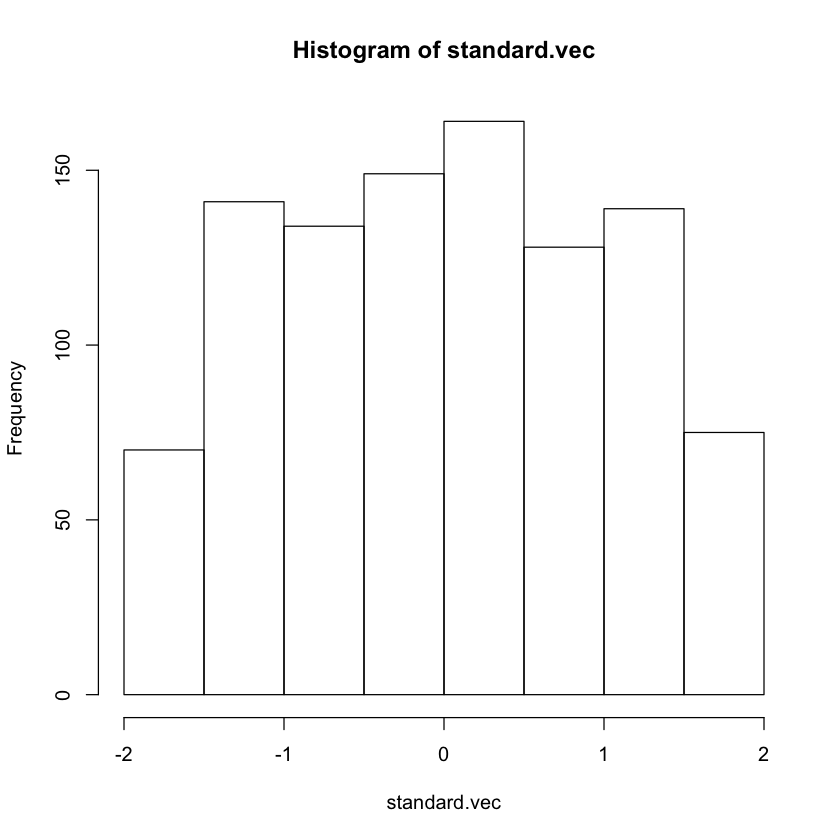

In [35]:
standard.vec <- scale(vec, scale=T, center=T)
hist(standard.vec)

#use log() or sqrt() to transform data for your needs

### Technique #4: Numerical Encoding

Some types of categorical data have an inherent ordering - for example, a person’s standing in college (Freshman < Sophomore < Junior < Senior). We might want to capture this when performing regression on data - to do so, we can convert categorical data into a numerical ordering.

In [32]:
a <- c(rep("Freshman",2),rep("Sophomore",2),rep("Junior",2),rep("Senior",2))
a

#simple way of doing it
a[which(a=="Freshman")] <- 1
a[which(a=="Sophomore")] <- 2
a[which(a=="Junior")] <- 3
a[which(a=="Senior")] <- 4
as.numeric(a)

#Second way: encode as factor

#create an unordered vector
a <- c(rep("Freshman",2),rep("Junior",2),rep("Sophomore",2),rep("Senior",2))
a

#define the order of factor in levels parameter
x <- factor(a, levels =c("Freshman", "Sophomore","Junior","Senior"))
x <- as.numeric(x)
x

[1] "Freshman"  "Freshman"  "Sophomore" "Sophomore" "Junior"    "Junior"   
[7] "Senior"    "Senior"

[1] 1 1 2 2 3 3 4 4

[1] "Freshman"  "Freshman"  "Junior"    "Junior"    "Sophomore" "Sophomore"
[7] "Senior"    "Senior"

[1] 1 1 3 3 2 2 4 4

### Technique #5: Dummy Variables

In R, factors are stored internally as numbers. For example, if your dataset was a list of people enrolled in the Cornell Data Science training program, the `Major` feature could be stored as 0 for Computer Science, 1 for Information Science, and so on. If you have a factor with n levels, you can create n binary dummy variables, each one representing whether the factor takes on its corresponding level.
        
To use the example above, you could have a `ComputerScience` variable which is 0 if the student's major is not computer science and 1 if the student's major is computer science. You could create an `InformationScience` feature in a similar way, and so on.

Dummy variables make models more interpretable and allow you to isolate the effects that certain levels of categorical features can have.

In [33]:
# Code example
a
model.matrix(~a-1)

[1] "Freshman"  "Freshman"  "Junior"    "Junior"    "Sophomore" "Sophomore"
[7] "Senior"    "Senior"

,aFreshman,aJunior,aSenior,aSophomore
1,1,0,0,0
2,1,0,0,0
3,0,1,0,0
4,0,1,0,0
5,0,0,0,1
6,0,0,0,1
7,0,0,1,0
8,0,0,1,0



## Terms to Review

* Vectorization
* Initialization
* Apply family
* Filtering
* Subsetting
* Merging
* Joining
* Mutating
* Summarizing
* Binning
* Normalizing
* Standardizing
* Ordering
* Dummy variable

## Sources

[1] http://yetanothermathprogrammingconsultant.blogspot.com/2016/06/loops-considered-harmful.html

[2] http://www.noamross.net/blog/2014/4/16/vectorization-in-r--why.html

[3] https://github.com/jimhester/lintr

[4] https://cran.r-project.org/doc/contrib/de_Jonge+van_der_Loo-Introduction_to_data_cleaning_with_R.pdf

[5] http://data-informed.com/how-to-improve-machine-learning-tricks-and-tips-for-feature-engineering
